In [1]:
pip install torch torchvision numpy matplotlib opencv-python


In [2]:
import cv2
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Bounding Box 1 Feature Shape: torch.Size([1, 1000])
Bounding Box 2 Feature Shape: torch.Size([1, 1000])
Bounding Box 3 Feature Shape: torch.Size([1, 1000])


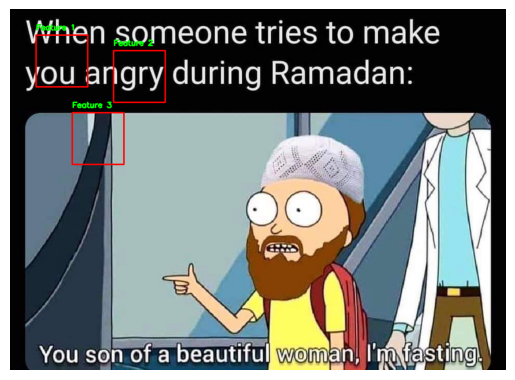

In [4]:

# Step 1: Crop and resize bounding box regions
def crop_and_resize(img, bounding_boxes, size=(224, 224)):
    cropped_regions = []
    for box in bounding_boxes:
        xmin, ymin, xmax, ymax = map(int, box)  # Ensure integer values
        cropped = img[ymin:ymax, xmin:xmax]  # Crop the region
        if cropped.shape[0] > 0 and cropped.shape[1] > 0:  # Validate crop
            resized = cv2.resize(cropped, size)  # Resize to required size
            cropped_regions.append(resized)
    return cropped_regions


# Step 2: Extract features using ResNet
def extract_resnet_features(img, bounding_boxes, model):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Ensure size is 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    features = []
    for box in bounding_boxes:
        xmin, ymin, xmax, ymax = map(int, box)
        cropped = img[ymin:ymax, xmin:xmax]  # Crop ROI
        if cropped.shape[0] > 0 and cropped.shape[1] > 0:  # Check valid crop
            input_tensor = preprocess(cropped).unsqueeze(0)  # Add batch dimension
            with torch.no_grad():
                feature = model(input_tensor)  # Extract features
            features.append(feature)
    return features


# Step 3: Annotate image with bounding boxes and feature labels
def annotate_image_with_features(img, bounding_boxes, features):
    image = img.copy()
    for i, box in enumerate(bounding_boxes):
        xmin, ymin, xmax, ymax = map(int, box)
        label = f"Feature {i+1}"  # You can customize labels here
        # Draw bounding box
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        # Add label text
        image = cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image


# Step 4: Load image and bounding box data
def load_image_with_bboxes(img_path, bounding_boxes):
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return img, bounding_boxes


# Example bounding box data (xmin, ymin, xmax, ymax)
# Replace this with your actual bounding box coordinates
example_bboxes = [
    [50, 50, 150, 150],
    [200, 80, 300, 180],
    [120, 200, 220, 300],
]

# Load a sample image (replace "sample.jpg" with your image path)
img_path = "/content/me2.jpg"  # Ensure the file exists in the same directory
img, bounding_boxes = load_image_with_bboxes(img_path, example_bboxes)


# Load pre-trained ResNet model
resnet = models.resnet50(pretrained=True)
resnet = resnet.eval()  # Set to evaluation mode

# Step 5: Crop, resize, and extract features
cropped_regions = crop_and_resize(img, bounding_boxes)
bounding_box_features = extract_resnet_features(img, bounding_boxes, resnet)

# Print feature shapes for each bounding box
for i, feature in enumerate(bounding_box_features):
    print(f"Bounding Box {i+1} Feature Shape:", feature.shape)

# Step 6: Annotate and visualize the image
annotated_img = annotate_image_with_features(img, bounding_boxes, bounding_box_features)
plt.imshow(annotated_img)
plt.axis("off")
plt.show()

In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


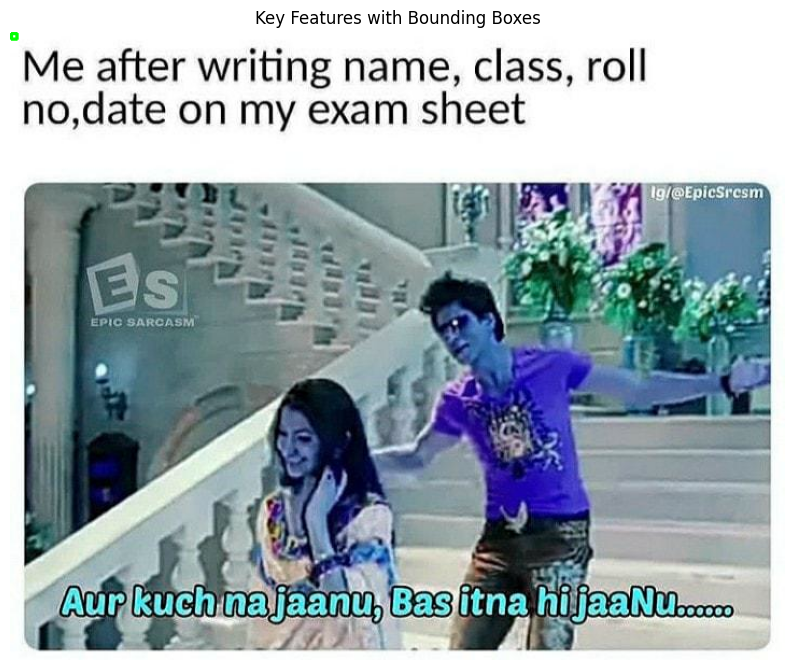

In [8]:
class ResNetFeatureExtractor:
    def __init__(self, model_name='resnet50', pretrained=True):
        """
        Initialize ResNet model for feature extraction

        Args:
            model_name (str): Name of the ResNet model (e.g., 'resnet50', 'resnet101')
            pretrained (bool): Whether to use pretrained weights
        """
        # Load the specified ResNet model
        if model_name == 'resnet50':
            self.model = models.resnet50(pretrained=pretrained)
        elif model_name == 'resnet101':
            self.model = models.resnet101(pretrained=pretrained)
        else:
            raise ValueError("Unsupported ResNet model. Choose 'resnet50' or 'resnet101'")

        # Remove the final classification layer
        self.model = torch.nn.Sequential(*list(self.model.children())[:-2])

        # Set the model to evaluation mode
        self.model.eval()

        # Image preprocessing transform
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def extract_features(self, image_path):
        """
        Extract features from the input image

        Args:
            image_path (str): Path to the input image

        Returns:
            tuple: Processed image, feature map, and original image
        """
        # Open the image
        original_image = Image.open(image_path).convert('RGB')

        # Preprocess the image
        input_tensor = self.transform(original_image)
        input_batch = input_tensor.unsqueeze(0)

        # Extract features
        with torch.no_grad():
            feature_map = self.model(input_batch)

        return input_tensor, feature_map, original_image

    def get_key_features(self, feature_map, top_k=10):
        """
        Extract key features based on feature map activation

        Args:
            feature_map (torch.Tensor): Feature map from ResNet
            top_k (int): Number of top features to extract

        Returns:
            list: Bounding boxes of key features
        """
        # Convert feature map to numpy for processing
        feature_map_np = feature_map.squeeze().mean(dim=0).numpy()

        # Threshold and find connected components
        _, thresh = cv2.threshold(feature_map_np,
                                  feature_map_np.mean(),
                                  255,
                                  cv2.THRESH_BINARY)
        thresh = thresh.astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(thresh,
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

        # Sort contours by area and select top k
        contours = sorted(contours, key=cv2.contourArea, reverse=True)[:top_k]

        # Convert contours to bounding boxes
        bounding_boxes = []
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Scale up to original image size (224 -> original)
            bounding_boxes.append((x, y, w, h))

        return bounding_boxes

    def visualize_features(self, image_path, output_path=None):
        """
        Visualize key features with bounding boxes

        Args:
            image_path (str): Path to input image
            output_path (str, optional): Path to save output image
        """
        # Extract features
        input_tensor, feature_map, original_image = self.extract_features(image_path)

        # Get key features (bounding boxes)
        bounding_boxes = self.get_key_features(feature_map)

        # Convert original image to numpy for drawing
        img_np = np.array(original_image)

        # Draw bounding boxes
        for (x, y, w, h) in bounding_boxes:
            cv2.rectangle(img_np,
                          (x, y),
                          (x+w, y+h),
                          (0, 255, 0),  # Green color
                          2)  # Line thickness

        # Plot the image
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB))
        plt.title('Key Features with Bounding Boxes')
        plt.axis('off')

        # Save or show the image
        if output_path:
            plt.savefig(output_path)
        else:
            plt.show()

# Example usage
if __name__ == '__main__':
    # Create feature extractor
    extractor = ResNetFeatureExtractor()

    # Visualize features for a specific image
    extractor.visualize_features('/content/3_NM_pic.jpg',
                                 output_path='output_features.jpg')

In [16]:
from google.colab import files

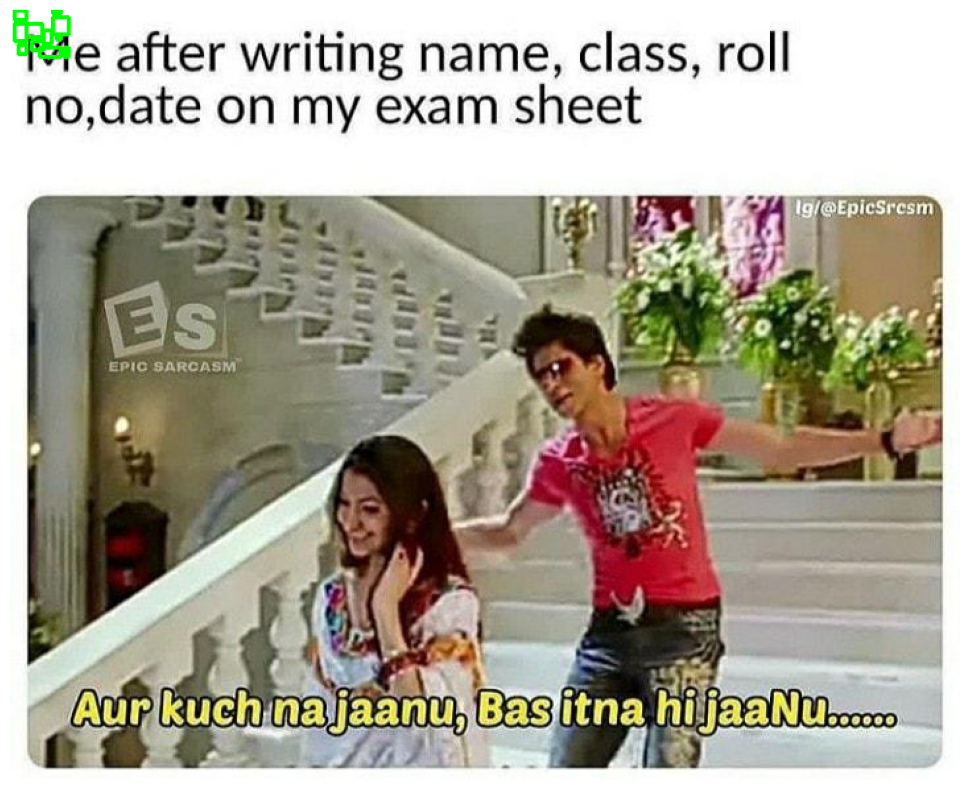

In [17]:
class ResNetBoundingBox:
    def __init__(self):
        # Load pre-trained ResNet model
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Modify model to extract features from intermediate layers
        self.features_extractor = torch.nn.Sequential(
            self.model.conv1,
            self.model.bn1,
            self.model.relu,
            self.model.maxpool,
            self.model.layer1,
            self.model.layer2,
            self.model.layer3
        )

        # Preprocessing transform
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def extract_features_and_draw_boxes(self, image_path):
        # Read image
        original_image = cv2.imread(image_path)

        # Preprocess image for tensor
        input_image = cv2.resize(original_image, (224, 224))
        input_tensor = self.transform(input_image).unsqueeze(0)

        # Extract features
        with torch.no_grad():
            features = self.features_extractor(input_tensor)

        # Process feature map
        feature_map = features.squeeze().mean(dim=0).numpy()
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
        feature_map_uint8 = (feature_map * 255).astype(np.uint8)

        # Threshold and find contours
        _, binary = cv2.threshold(feature_map_uint8, 127, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            # Scale coordinates to original image size
            scale_x = original_image.shape[1] / 224
            scale_y = original_image.shape[0] / 224

            x_orig = int(x * scale_x)
            y_orig = int(y * scale_y)
            w_orig = int(w * scale_x)
            h_orig = int(h * scale_y)

            cv2.rectangle(original_image,
                          (x_orig, y_orig),
                          (x_orig + w_orig, y_orig + h_orig),
                          (0, 255, 0), 2)

        # Save and show image
        cv2.imwrite('output_bounding_boxes.jpg', original_image)
        plt.figure(figsize=(15,10))
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

# Usage
detector = ResNetBoundingBox()
detector.extract_features_and_draw_boxes('/content/3_NM_pic.jpg')

Saving 3_NM_pic.jpg to 3_NM_pic (1).jpg


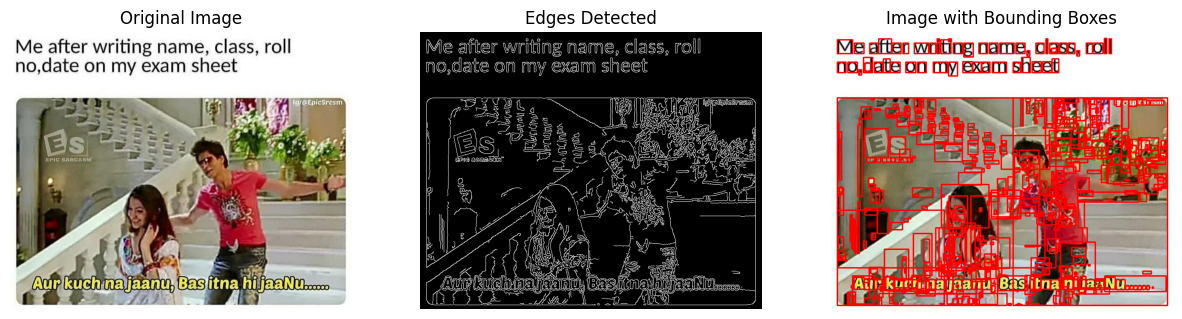

In [19]:
uploaded = files.upload()  # Upload your image file
img_path = next(iter(uploaded.keys()))  # Get the uploaded file's name

# Step 4: Load the image
def load_image(img_path):
    img = cv2.imread(img_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return img

img = load_image(img_path)

# Step 5: Detect important features using Canny Edge Detection
def detect_edges(img, threshold1=100, threshold2=200):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray, threshold1, threshold2)  # Perform Canny edge detection
    return edges

edges = detect_edges(img)

# Step 6: Find contours (regions of interest) based on edges
def find_bounding_boxes(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]  # Get bounding boxes
    return bounding_boxes

bounding_boxes = find_bounding_boxes(edges)

# Step 7: Draw bounding boxes on the image
def draw_bounding_boxes(img, bounding_boxes):
    image_with_boxes = img.copy()
    for (x, y, w, h) in bounding_boxes:
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)  # Draw bounding box
    return image_with_boxes

image_with_boxes = draw_bounding_boxes(img, bounding_boxes)

# Step 8: Plot the original image, edges, and image with bounding boxes
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap="gray")
plt.title("Edges Detected")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image_with_boxes)
plt.title("Image with Bounding Boxes")
plt.axis("off")

plt.show()

Saving 3_NM_pic.jpg to 3_NM_pic (2).jpg


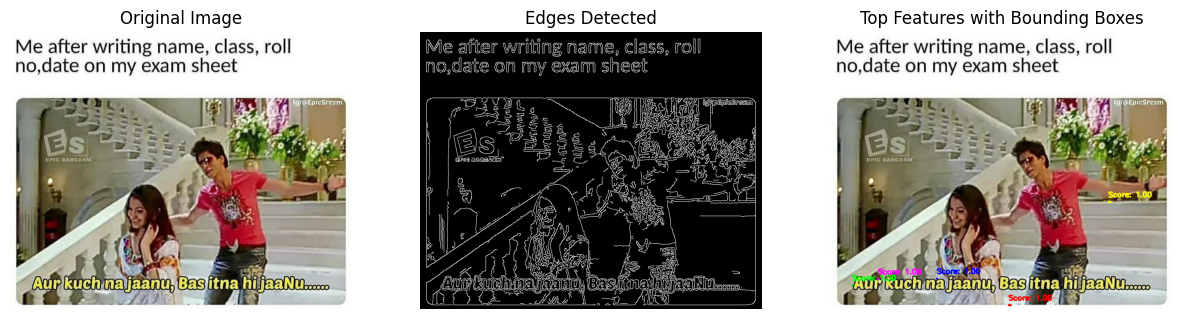

Top Feature Scores: [1.0, 1.0, 1.0, 1.0, 1.0]


In [20]:
uploaded = files.upload()  # Upload your image file
img_path = next(iter(uploaded.keys()))  # Get the uploaded file's name

# Step 4: Load the image
def load_image(img_path):
    img = cv2.imread(img_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return img

img = load_image(img_path)

# Step 5: Detect important features using Canny Edge Detection
def detect_edges(img, threshold1=100, threshold2=200):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray, threshold1, threshold2)  # Perform Canny edge detection
    return edges

edges = detect_edges(img)

# Step 6: Find contours (regions of interest) based on edges
def find_bounding_boxes_and_scores(edges):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []
    feature_scores = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)  # Get bounding box
        box_area = w * h  # Area of the bounding box
        edge_area = cv2.countNonZero(edges[y:y+h, x:x+w])  # Count edges inside the bounding box
        feature_score = edge_area / box_area if box_area > 0 else 0  # Calculate feature score
        if feature_score > 0.01:  # Ignore insignificant bounding boxes
            bounding_boxes.append((x, y, w, h))
            feature_scores.append(feature_score)

    # Sort by feature scores in descending order
    sorted_indices = np.argsort(feature_scores)[::-1]
    bounding_boxes = [bounding_boxes[i] for i in sorted_indices]
    feature_scores = [feature_scores[i] for i in sorted_indices]

    return bounding_boxes, feature_scores

bounding_boxes, feature_scores = find_bounding_boxes_and_scores(edges)

# Step 7: Draw bounding boxes with scores on the image
def draw_bounding_boxes(img, bounding_boxes, feature_scores, top_n=5):
    image_with_boxes = img.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]  # Colors for top boxes

    for idx, (box, score) in enumerate(zip(bounding_boxes[:top_n], feature_scores[:top_n])):
        x, y, w, h = box
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        color = colors[idx % len(colors)]
        cv2.rectangle(image_with_boxes, top_left, bottom_right, color, 2)  # Draw bounding box
        label = f"Score: {score:.2f}"
        cv2.putText(image_with_boxes, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Add score label

    return image_with_boxes

image_with_boxes = draw_bounding_boxes(img, bounding_boxes, feature_scores, top_n=5)

# Step 8: Plot the original image, edges, and image with bounding boxes
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap="gray")
plt.title("Edges Detected")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image_with_boxes)
plt.title("Top Features with Bounding Boxes")
plt.axis("off")

plt.show()

# Step 9: Print the feature scores
print("Top Feature Scores:", feature_scores[:5])

In [22]:
import os

In [23]:
uploaded = files.upload()  # Upload your image file
img_path = next(iter(uploaded.keys()))  # Get the uploaded file's name

# Step 4: Load the image
def load_image(img_path):
    img = cv2.imread(img_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return img

img = load_image(img_path)

# Step 5: Load the MobileNet SSD Model
def load_detection_model():
    model = {
        "prototxt": "https://github.com/chuanqi305/MobileNet-SSD/raw/master/deploy.prototxt",
        "caffemodel": "https://github.com/chuanqi305/MobileNet-SSD/raw/master/MobileNetSSD_deploy.caffemodel",
    }
    prototxt_path = "deploy.prototxt"
    caffemodel_path = "MobileNetSSD_deploy.caffemodel"
    for url, path in zip(model.values(), [prototxt_path, caffemodel_path]):
        if not os.path.exists(path):
            !wget {url} -O {path}
    net = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)
    return net

net = load_detection_model()

# Step 6: Define the class labels for MobileNet SSD
class_labels = [
    "background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]

# Step 7: Perform object detection
def detect_objects(net, img, conf_threshold=0.5):
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()

    bounding_boxes = []
    scores = []
    labels = []

    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            idx = int(detections[0, 0, i, 1])
            label = class_labels[idx]
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            bounding_boxes.append((startX, startY, endX - startX, endY - startY))
            scores.append(confidence)
            labels.append(label)
    return bounding_boxes, scores, labels

bounding_boxes, scores, labels = detect_objects(net, img)

# Step 8: Draw bounding boxes with labels and scores
def draw_bounding_boxes(img, bounding_boxes, scores, labels):
    image_with_boxes = img.copy()
    for (box, score, label) in zip(bounding_boxes, scores, labels):
        x, y, w, h = box
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        color = (255, 0, 0)
        cv2.rectangle(image_with_boxes, top_left, bottom_right, color, 2)  # Draw bounding box
        text = f"{label}: {score:.2f}"
        cv2.putText(image_with_boxes, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)  # Add label
    return image_with_boxes

image_with_boxes = draw_bounding_boxes(img, bounding_boxes, scores, labels)

# Step 9: Plot the original image and image with bounding boxes
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image_with_boxes)
plt.title("Image with Detected Objects")
plt.axis("off")

plt.show()

# Step 10: Print detected objects and scores
for label, score in zip(labels, scores):
    print(f"Object: {label}, Score: {score:.2f}")

Saving me2.jpg to me2 (3).jpg
--2025-01-26 21:49:07--  https://github.com/chuanqi305/MobileNet-SSD/raw/master/deploy.prototxt
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/deploy.prototxt [following]
--2025-01-26 21:49:08--  https://raw.githubusercontent.com/chuanqi305/MobileNet-SSD/master/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44667 (44K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  43.62K  --.-KB/s    in 0.004s  

2025-01-26 21:49:08 (12.0 MB/s) - ‘deploy.prototxt’ saved [44667/44667]

--20

error: OpenCV(4.10.0) /io/opencv/modules/dnn/src/layers/convolution_layer.cpp:368: error: (-215:Assertion failed) !blobs.empty() || inputs.size() > 1 in function 'getMemoryShapes'
